In [1]:
import csv
import pickle
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
from dataclasses import dataclass
from absl import logging
logging.set_verbosity(logging.ERROR)

In [31]:
STD_PATH = './daily-min-temperatures.csv'
TEMPERATURES_CSV = STD_PATH
with open(TEMPERATURES_CSV, 'r') as csvfile:
    print(f"Header looks like this:\n\n{csvfile.readline()}")
    print(f"First data point looks like this:\n\n{csvfile.readline()}")
    print(f"Second data point looks like this:\n\n{csvfile.readline()}")

Header looks like this:

"Date","Temp"

First data point looks like this:

"1981-01-01",20.7

Second data point looks like this:

"1981-01-02",17.9



In [32]:
def plot_series(time, series, format="-", start=0, end=None):
    plt.plot(time[start:end], series[start:end], format)
    plt.xlabel("Time")
    plt.ylabel("Value")
    plt.grid(True)

In [9]:
def parse_data_from_file(filename):

    times = []
    temperatures = []

    with open(filename) as csvfile:
        counter = 0
        reader = csv.reader(csvfile, delimiter=',')
        next(reader)
        for row in reader:
            times.append(counter)
            counter+=1
            temperatures.append(float(row[1]))

    return times, temperatures

Make a global class referring to variables, for easy manipulation

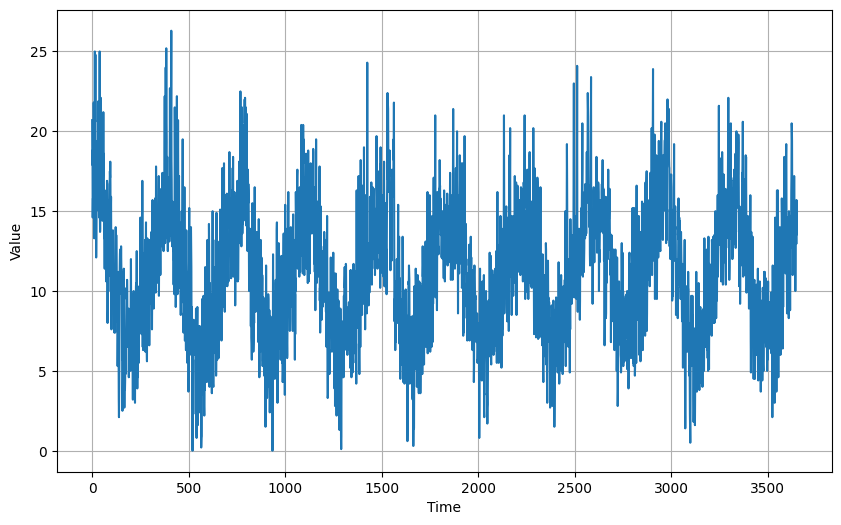

In [33]:
class G:
    TEMPERATURES_CSV = STD_PATH
    times, temperatures = parse_data_from_file(TEMPERATURES_CSV)
    TIME = np.array(times)
    SERIES = np.array(temperatures)
    SPLIT_TIME = 2500
    WINDOW_SIZE = 64
    BATCH_SIZE = 32
    SHUFFLE_BUFFER_SIZE = 1000


plt.figure(figsize=(10, 6))
plot_series(G.TIME, G.SERIES)
plt.show()

In [13]:
def train_val_split(time, series, time_step=G.SPLIT_TIME):

    time_train = time[:time_step]
    series_train = series[:time_step]
    time_valid = time[time_step:]
    series_valid = series[time_step:]

    return time_train, series_train, time_valid, series_valid


# Splitting the dataset
time_train, series_train, time_valid, series_valid = train_val_split(G.TIME, G.SERIES)

In [14]:
def windowed_dataset(series, window_size=G.WINDOW_SIZE, batch_size=G.BATCH_SIZE, shuffle_buffer=G.SHUFFLE_BUFFER_SIZE):
    ds = tf.data.Dataset.from_tensor_slices(series)
    ds = ds.window(window_size + 1, shift=1, drop_remainder=True)
    ds = ds.flat_map(lambda w: w.batch(window_size + 1))
    ds = ds.shuffle(shuffle_buffer)
    ds = ds.map(lambda w: (w[:-1], w[-1]))
    ds = ds.batch(batch_size).prefetch(1)
    return ds


# Applying the transformation to the training set
train_set = windowed_dataset(series_train, window_size=G.WINDOW_SIZE, batch_size=G.BATCH_SIZE, shuffle_buffer=G.SHUFFLE_BUFFER_SIZE)

In [15]:
def LSTM_NonLambda_model():

    model = tf.keras.models.Sequential([
        tf.keras.layers.Conv1D(filters = 32, kernel_size = 3, strides = 1, activation = 'relu', padding = 'causal', input_shape = [G.WINDOW_SIZE, 1]),
        tf.keras.layers.LSTM(32, return_sequences=True),
        tf.keras.layers.LSTM(30),
        tf.keras.layers.Dense(30, activation="relu"),
        tf.keras.layers.Dense(12, activation="relu"),
        tf.keras.layers.Dense(1),
    ])

    return model

**HyperParameter Tuning - LRScheduling using callbacks**

In [16]:
def adjust_learning_rate(dataset):

    model = create_uncompiled_model()

    lr_schedule = tf.keras.callbacks.LearningRateScheduler(lambda epoch: 1e-4 * 10**(epoch / 20))

    ### START CODE HERE

    # Select your optimizer
    optimizer = tf.keras.optimizers.SGD(momentum = 0.9)

    # Compile the model passing in the appropriate loss
    model.compile(loss=tf.keras.losses.Huber(),
                  optimizer=optimizer,
                  metrics=["mae"])

    ### END CODE HERE

    history = model.fit(dataset, epochs=100, callbacks=[lr_schedule])

    return history

In [17]:
lr_history = adjust_learning_rate(train_set)

Epoch 1/100
77/77 [==============================] - 10s 57ms/step - loss: 9.9995 - mae: 10.4980 - lr: 1.0000e-04
Epoch 2/100
77/77 [==============================] - 6s 73ms/step - loss: 9.7357 - mae: 10.2343 - lr: 1.1220e-04
Epoch 3/100
77/77 [==============================] - 4s 53ms/step - loss: 9.3342 - mae: 9.8325 - lr: 1.2589e-04
Epoch 4/100
77/77 [==============================] - 5s 56ms/step - loss: 8.5615 - mae: 9.0597 - lr: 1.4125e-04
Epoch 5/100
77/77 [==============================] - 4s 52ms/step - loss: 6.4735 - mae: 6.9647 - lr: 1.5849e-04
Epoch 6/100
77/77 [==============================] - 5s 66ms/step - loss: 2.9324 - mae: 3.3985 - lr: 1.7783e-04
Epoch 7/100
77/77 [==============================] - 5s 57ms/step - loss: 2.3665 - mae: 2.8267 - lr: 1.9953e-04
Epoch 8/100
77/77 [==============================] - 5s 57ms/step - loss: 2.1665 - mae: 2.6240 - lr: 2.2387e-04
Epoch 9/100
77/77 [==============================] - 4s 53ms/step - loss: 2.0022 - mae: 2.4560 - lr: 

(0.0001, 10.0, 0.0, 10.0)

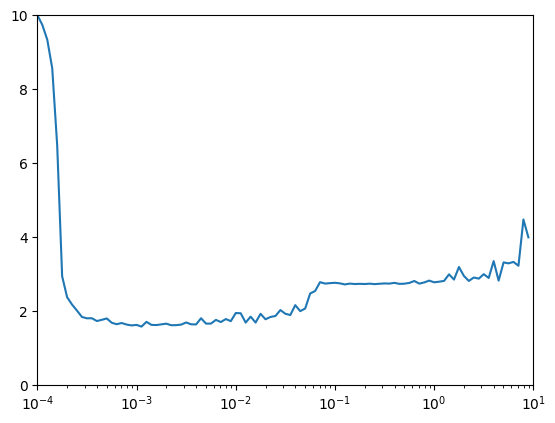

In [18]:
plt.semilogx(lr_history.history["lr"], lr_history.history["loss"])
plt.axis([1e-4, 10, 0, 10])

In [19]:
def create_model():


    model = create_uncompiled_model()

    ### START CODE HERE

    model.compile(loss= tf.keras.losses.Huber(),
                  optimizer=tf.keras.optimizers.SGD(momentum=0.9, learning_rate = 0.0056),
                  metrics=["mae"])


    ### END CODE HERE

    return model

In [20]:
# Save an instance of the model
model = create_model()

# Train it
history = model.fit(train_set, epochs=50, verbose = 1)


Epoch 1/50
77/77 [==============================] - 8s 53ms/step - loss: 4.9526 - mae: 5.4296
Epoch 2/50
77/77 [==============================] - 5s 66ms/step - loss: 2.0209 - mae: 2.4746
Epoch 3/50
77/77 [==============================] - 5s 58ms/step - loss: 2.1065 - mae: 2.5644
Epoch 4/50
77/77 [==============================] - 5s 59ms/step - loss: 1.7670 - mae: 2.2197
Epoch 5/50
77/77 [==============================] - 4s 54ms/step - loss: 1.7032 - mae: 2.1498
Epoch 6/50
77/77 [==============================] - 5s 66ms/step - loss: 1.7221 - mae: 2.1710
Epoch 7/50
77/77 [==============================] - 5s 58ms/step - loss: 1.7338 - mae: 2.1834
Epoch 8/50
77/77 [==============================] - 4s 53ms/step - loss: 1.6065 - mae: 2.0533
Epoch 9/50
77/77 [==============================] - 7s 89ms/step - loss: 1.5955 - mae: 2.0397
Epoch 10/50
77/77 [==============================] - 6s 74ms/step - loss: 1.7018 - mae: 2.1535
Epoch 11/50
77/77 [==============================] - 5s 64m

To compare forecasts, we ues windowed forecasting to save time using batches of data

In [22]:
def model_forecast(model, series, window_size):
    ds = tf.data.Dataset.from_tensor_slices(series)
    ds = ds.window(window_size, shift=1, drop_remainder=True)
    ds = ds.flat_map(lambda w: w.batch(window_size))
    ds = ds.batch(32).prefetch(1)
    forecast = model.predict(ds)
    return forecast

113/113 [==============================] - 3s 23ms/step


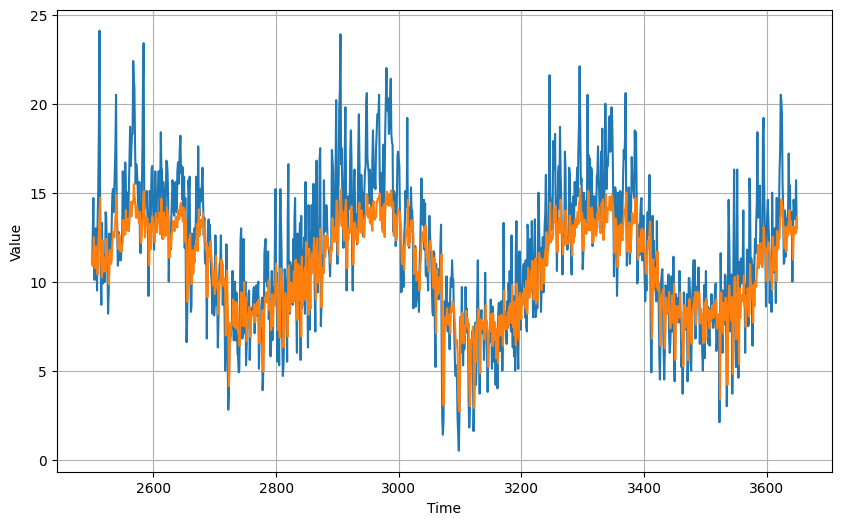

In [34]:
# Compute the forecast for all the series
rnn_forecast = model_forecast(model, G.SERIES, G.WINDOW_SIZE).squeeze()

# Slice the forecast to get only the predictions for the validation set
rnn_forecast = rnn_forecast[G.SPLIT_TIME - G.WINDOW_SIZE:-1]

# Plot the forecast
plt.figure(figsize=(10, 6))
plot_series(time_valid, series_valid)
plot_series(time_valid, rnn_forecast)

In [35]:
def compute_metrics(true_series, forecast):

    mse = tf.keras.metrics.mean_squared_error(true_series, forecast).numpy()
    mae = tf.keras.metrics.mean_absolute_error(true_series, forecast).numpy()

    return mse, mae

In [36]:
compute_metrics(series_valid, rnn_forecast)

(6.6414814, 2.006062)